# HDS 5210 Final Project - Derek Dixon
## Healthcare Spending, Happiness, and GDP - An Exploration

In this project I utilize datasets from Kaggle and the World Bank to explore the correlations between healthcare spending per capita, happiness levels, and GDP per capita by country in 2015-2018. 

My prior is that all three things will correlate positively for most countries. Higher productivey and prosperity (GDP) is associated with (careful not to say *causes*) greater health spending per capita, which are both associated with higher measures of happiness amongst the population.

Without further adu, let's pull these data in and see where this analyis takes us!


# Healthcare Spending Per Capita

This data comes from The World Bank. Link can be found here:
https://data.worldbank.org/indicator/SH.XPD.CHEX.PC.CD


In [1]:
# Importing Libraries
import pandas as pd
from lxml import objectify

# File paths
XML_FILE = "healthcare_spend.xml"

# Creating empty output dictionary
output = {"Country": [], "Year": [], "Value": []}

# Loading the data as an xml
root = objectify.parse(open(XML_FILE)).getroot()

# Parsing through the file to populate the output object
for records in root.data.getchildren():
    output['Country'].append(records.getchildren()[0].text)
    output['Year'].append(records.getchildren()[2].text)
    output['Value'].append(records.getchildren()[3].text)

# Converting to a pandas dataframe
hc_spend_df = pd.DataFrame(output)

# Checking 
hc_spend_df.head()


,Country,Year,Value
0,Aruba,1960,None
1,Aruba,1961,None
2,Aruba,1962,None
3,Aruba,1963,None
4,Aruba,1964,None


There are several questions we must ask oursevles to understand our dataset, such as how many countries are there, how many years does it cover, are there missing values, etc etc.
First, let's explore its dimensions.

In [2]:
hc_spend_df.shape

(16104, 3)

It's worth noting that this dataframe is in *long* form (or *tidy*, as we say in the R world). We could pivot it by Year such that each row would be a unqiue country. This would make the dataframe *wide*. Let's do this now.

In [3]:
# Imporing NumPy
import numpy as np

# Pivoting long to wide
hc_spend_wide = hc_spend_df.pivot(index = "Country", columns = 'Year', values = 'Value').reset_index()

# Checking result
hc_spend_wide.head()

Year,Country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,None,None,None,None,None,None,None,None,None,...,50.85347366,51.44026184,55.03462982,59.00893402,58.90652847,60.18867111,65.70602417,49.84260941,None,None
1,Albania,None,None,None,None,None,None,None,None,None,...,211.07551575,213.71974182,236.95796204,251.35826111,192.88513184,202.01332092,226.28067017,274.91409302,None,None
2,Algeria,None,None,None,None,None,None,None,None,None,...,287.3861084,335.56195068,331.94168091,359.64212036,291.55355835,260.77255249,258.03955078,255.86943054,None,None
3,American Samoa,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Andorra,None,None,None,None,None,None,None,None,None,...,2567.52539063,2342.56835938,2432.78271484,2529.08984375,2246.25439453,2361.2175293,2567.42382813,2821.80126953,None,None


In [4]:
hc_spend_wide.shape

(264, 62)

We can see from the shape command that there are 264 rows corresponding to 264 unique countries. We also see there are 60 years of data, from 1960 to 2020, although it's not all complete. Our other datasets that we will eventually join to only cover 2015-2019 so any other years can be dropped.

In [5]:
hc_spend_wide[["2015", "2016", "2017", "2018", "2019"]].head()

Year,2015,2016,2017,2018,2019
0,58.90652847,60.18867111,65.70602417,49.84260941,None
1,192.88513184,202.01332092,226.28067017,274.91409302,None
2,291.55355835,260.77255249,258.03955078,255.86943054,None
3,None,None,None,None,None
4,2246.25439453,2361.2175293,2567.42382813,2821.80126953,None


It looks like 2019 might contain a lot of missingness. Let's see. We can check directly using a set() command, or use a isnull filter and look at the shape.

In [6]:
set(hc_spend_wide["2019"])

{None}

In [7]:
# Creating a filter
filt = pd.isnull(hc_spend_wide["2019"])

# Applying filter
hc_spend_wide[filt].shape

(264, 62)

So we see that the 2019 column is useless and can be dropped as well. Well, what about 2018? Is there a lot of missingness there?

In [8]:
# Creating a filter
filt = pd.isnull(hc_spend_wide["2018"])

# Applying filter
hc_spend_wide[filt].shape

(31, 62)

Only 31 of the 264 countries have missing data for 2018. 

Let's explore the top 10 and bottom 10 countries!

First we will have to convert the year columns to numeric.

In [9]:
hc_spend_wide[["2015", "2016", "2017", "2018"]] = hc_spend_wide[["2015", "2016", "2017", "2018"]].apply(pd.to_numeric)

In [10]:
hc_spend_wide[["Country", "2018"]].sort_values('2018', ascending = False)[0:10]

Year,Country,2018
251,United States,10623.849609
177,North America,10050.278762
233,Switzerland,9870.664062
180,Norway,8239.095703
108,Iceland,6530.932129
144,Luxembourg,6227.083984
56,Denmark,6216.768555
232,Sweden,5981.706055
195,Post-demographic dividend,5832.108804
99,High income,5562.344755


The United States is number one, spending 10,624 dollars per citizen in 2018. A few of these aren't actually countries but groups of countries. We will probably need to drop these later when joining to the other datasets but for now it's fine.

In [11]:
# List of 10 top per capita spenders (including the aggregated "countries")
top_10 = hc_spend_wide[["Country","2018"]].sort_values('2018', ascending = False)[0:10].reset_index().Country.to_list()

top_10

['United States',
 'North America',
 'Switzerland',
 'Norway',
 'Iceland',
 'Luxembourg',
 'Denmark',
 'Sweden',
 'Post-demographic dividend',
 'High income']

In [12]:
# List of relevant years
years = ["Country", "2015", "2016", "2017", "2018"]

# Looking at the top 10 spenders
top_10_df = hc_spend_wide[years][hc_spend_wide.Country.isin(top_10)]

top_10_df

Year,Country,2015,2016,2017,2018
56,Denmark,5469.334961,5565.593262,5800.152832,6216.768555
99,High income,4936.109899,5099.667610,5291.345301,5562.344755
108,Iceland,4281.575684,5067.690918,6109.912109,6530.932129
144,Luxembourg,5421.932129,5475.139648,5713.118652,6227.083984
177,North America,9002.600503,9348.178146,9667.407506,10050.278762
180,Norway,7565.549805,7496.768555,7815.786621,8239.095703
195,Post-demographic dividend,5175.288473,5356.201778,5544.404333,5832.108804
232,Sweden,5595.033203,5674.477539,5838.215332,5981.706055
233,Switzerland,9382.791016,9439.424805,9606.349609,9870.664062
251,United States,9491.090820,9877.871094,10209.630859,10623.849609


Let's visualize this with some plots using seaborn. It will be easier to do using long-form data, so I will revert back to the original dataset and filter back down

In [13]:
# Making a list of the years we care about
years_only = ["2015", "2016", "2017", "2018"]

# Applying that list
top_10_df_long = hc_spend_df[hc_spend_df.Country.isin(top_10)][hc_spend_df.Year.isin(years_only)]

top_10_df_long.head()

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Country,Year,Value
2190,Switzerland,2015,9382.79101563
2191,Switzerland,2016,9439.42480469
2192,Switzerland,2017,9606.34960938
2193,Switzerland,2018,9870.6640625
3471,Denmark,2015,5469.33496094


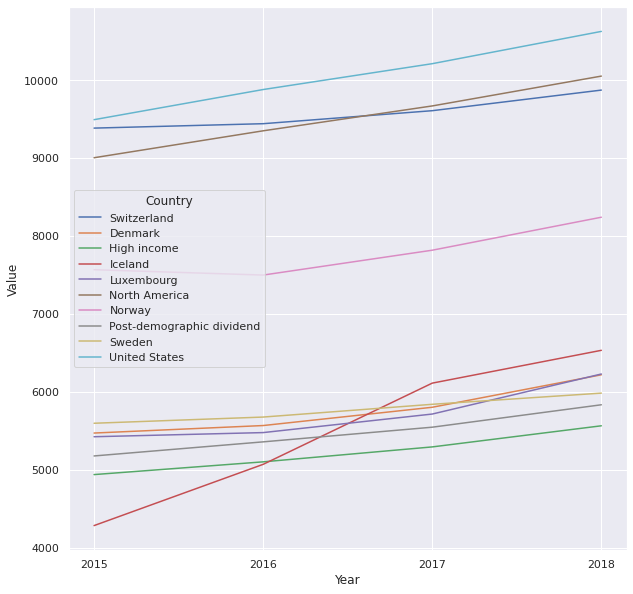

In [14]:
# Let's give seaborn a shot!
import seaborn as sns

# Have to make sure this column is numeric for the plot to work
top_10_df_long["Value"] = pd.to_numeric(top_10_df_long["Value"])

# Setting figure size
sns.set(rc = {'figure.figsize': (10, 10)})
# Plot
sns.lineplot(data = top_10_df_long, x = "Year", y = "Value", hue = "Country", markers = True)

The trend is steady increases but most countries holding their place. Iceland is an interesting exception, starting off at last but rising to 5th by 2018. 

# World Happiness Data

This data comes from the World Happiness Report dataset from Kaggle. Found here:
https://www.kaggle.com/unsdsn/world-happiness

There are 5 years worth of data stored in seperate .csv files.

In [15]:
# Importing libraries
import pandas as pd

# Reading in the .csv files with pandas
happy_2015 = pd.read_csv("2015.csv")
happy_2016 = pd.read_csv("2016.csv")
happy_2017 = pd.read_csv("2017.csv")
happy_2018 = pd.read_csv("2018.csv")
happy_2019 = pd.read_csv("2019.csv")

# Glimpsing at a file
happy_2015.head()


,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [16]:
# Checking the sizes of the files

print("2015: ", happy_2015.shape)
print("2016: ", happy_2016.shape)
print("2017: ", happy_2017.shape)
print("2018: ", happy_2018.shape)
print("2019: ", happy_2019.shape)

2015:  (158, 12)
2016:  (157, 13)
2017:  (155, 12)
2018:  (156, 9)
2019:  (156, 9)


In [17]:
# Probably would be good to see the heads of the other files as well so that we can select the needed fields to coherently join them

happy_2016.head()

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


In [18]:
happy_2017.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [19]:
happy_2018.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [20]:
happy_2019.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Because these 5 files aren't exactly the same shape, I need to do some transformations before I can join or append them together.
I will select a few columns that appear in all 5 files, add a "year" field to each file, then append them.

In theory, these operations could be made as functions if we were to expect to use them again. However, these files don't lend themselves too well to that because the same columns have slightly different names across the files. This makes it tricky to modularize.

In [21]:
happy_2015["Year"] = 2015
happy_2016["Year"] = 2016
happy_2017["Year"] = 2017
happy_2018["Year"] = 2018
happy_2019["Year"] = 2019

happy_2015["Score"] = happy_2015["Happiness Score"]
happy_2015["Health"] = happy_2015["Health (Life Expectancy)"]
happy_2016["Score"] = happy_2016["Happiness Score"]
happy_2016["Health"] = happy_2016["Health (Life Expectancy)"]

happy_2017["Score"] = happy_2017["Happiness.Score"]
happy_2017["Health"] = happy_2017["Health..Life.Expectancy."]

happy_2018["Country"] = happy_2018["Country or region"]
happy_2018["Health"] = happy_2018["Healthy life expectancy"]
happy_2018["Freedom"] = happy_2018["Freedom to make life choices"]

happy_2019["Country"] = happy_2019["Country or region"]
happy_2019["Health"] = happy_2019["Healthy life expectancy"]
happy_2019["Freedom"] = happy_2019["Freedom to make life choices"]

happy_2015_sel = happy_2015[["Country", "Year", "Score", "Health", "Freedom", "Generosity"]]
happy_2016_sel = happy_2016[["Country", "Year", "Score", "Health", "Freedom", "Generosity"]]
happy_2017_sel = happy_2017[["Country", "Year", "Score", "Health", "Freedom", "Generosity"]]
happy_2018_sel = happy_2018[["Country", "Year", "Score", "Health", "Freedom", "Generosity"]]
happy_2019_sel = happy_2019[["Country", "Year", "Score", "Health", "Freedom", "Generosity"]]

happy_2019_sel.head()


,Country,Year,Score,Health,Freedom,Generosity
0,Finland,2019,7.769,0.986,0.596,0.153
1,Denmark,2019,7.600,0.996,0.592,0.252
2,Norway,2019,7.554,1.028,0.603,0.271
3,Iceland,2019,7.494,1.026,0.591,0.354
4,Netherlands,2019,7.488,0.999,0.557,0.322


In [22]:
happy_all = happy_2015_sel.append(happy_2016_sel).append(happy_2017_sel).append(happy_2018_sel).append(happy_2019_sel)

happy_all.shape

(782, 6)

In [23]:
happy_all.head()

,Country,Year,Score,Health,Freedom,Generosity
0,Switzerland,2015,7.587,0.94143,0.66557,0.29678
1,Iceland,2015,7.561,0.94784,0.62877,0.43630
2,Denmark,2015,7.527,0.87464,0.64938,0.34139
3,Norway,2015,7.522,0.88521,0.66973,0.34699
4,Canada,2015,7.427,0.90563,0.63297,0.45811


Ok, we have the dataset in a combined form that we can now explore more easily, as well as join to the other datasets.

What if we group by Country and explore the average scores?

In [24]:
happy_all.groupby("Country").mean("Score").sort_values("Score", ascending = False)[["Score"]].head()

,Score
Country,
Denmark,7.5460
Norway,7.5410
Finland,7.5378
Switzerland,7.5114
Iceland,7.5110


We could also plot the scores by country over time using a line plot! First, let's capture the names of the top 10 happiest countries to limit the scope of the plot.

In [25]:
# Capturing the names top 10 highest scoring countries in 2018
top_10_happy = happy_all[happy_all["Year"] == 2018].sort_values('Score', ascending = False)[0:10].reset_index().Country.to_list()

top_10_happy

['Finland',
 'Norway',
 'Denmark',
 'Iceland',
 'Switzerland',
 'Netherlands',
 'Canada',
 'New Zealand',
 'Sweden',
 'Australia']

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


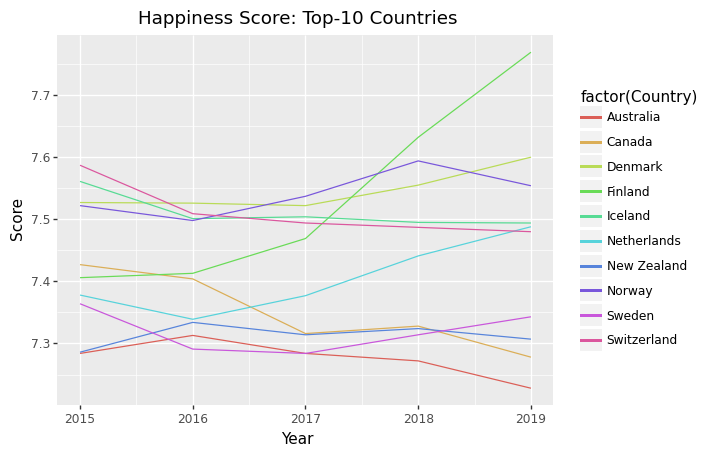

<ggplot: (8757879751267)>

In [26]:
# An interesting ggplot2 "port" library for python
from plotnine import ggplot, geom_line, aes, facet_wrap, ggtitle, ylab, xlab

# The plot! ggplot FTW
(ggplot(happy_all[happy_all.Country.isin(top_10_happy)], aes('Year', 'Score', color = 'factor(Country)'))
    + geom_line()
    + ggtitle("Happiness Score: Top-10 Countries"))


Interesting that these top 10 countries tend to stay level or incur slight increases. Although some of this variation might be small enough to be considered noise. Finland is a standout example. It was 6th in 2015, with a score of ~7.4, but reaches 1st by 2019 with a score of over 7.7.

Also, I really like having a grammar of graphics in python. Finally, plotting makes sense again!

# GDP per Capita Data

This is another Kaggle dataset:
https://www.kaggle.com/nitishabharathi/gdp-per-capita-all-countries

It contains the GDP per capita of all countries from 1990 to 2019.

In [27]:
# Importing libraries
import pandas as pd

# Reading in the .csv files with pandas
gdp = pd.read_excel("GDP.xlsx")

# Glimpsing at a file
gdp.head()


,Country,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,24101.109430,25870.755940,26533.343900,27430.752400,28656.520210,28648.990020,28499.089430,30215.949230,...,33732.847450,35492.618490,35498.982090,37419.892820,38223.372260,38249.054870,38390.271650,39454.629830,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1637.377987,1626.764793,1806.763930,1874.765634,1897.525938,1886.692977,1896.992520,1934.636754,1955.006208,NaN
2,Angola,AGO,3089.683369,3120.356148,2908.160798,2190.768160,2195.532289,2496.199493,2794.896906,2953.342709,...,6230.297028,6346.395122,6772.528333,6980.423038,7199.245478,7096.600615,6756.935074,6650.584940,6452.355165,NaN
3,Albania,ALB,2549.473022,1909.114038,1823.307673,2057.449657,2289.873135,2665.764906,2980.066288,2717.362124,...,9628.025783,10207.752350,10526.235450,10571.010650,11259.225890,11662.030480,11868.178970,12930.140030,13364.155400,NaN
4,Arab World,ARB,6808.206995,6872.273195,7255.328362,7458.647059,7645.682856,7774.207360,8094.149842,8397.515692,...,14127.778020,14518.827450,15423.465390,15824.780110,16153.244860,16501.792590,16935.383300,17099.889390,17570.137600,NaN


In [28]:
gdp.shape

(260, 32)

Going to only select the columns that we have in the other datasets, namely 2015-2018. I'll also drop countries with missingness.

In [29]:
# Reducing to only the size we need and cleaning it up

# Fixing a column name issue
gdp["Country"] = gdp["Country "]

gdp = gdp[["Country", 2015, 2016, 2017, 2018]].dropna()

gdp.head()

,Country,2015,2016,2017,2018
1,Afghanistan,1886.692977,1896.992520,1934.636754,1955.006208
2,Angola,7096.600615,6756.935074,6650.584940,6452.355165
3,Albania,11662.030480,11868.178970,12930.140030,13364.155400
4,Arab World,16501.792590,16935.383300,17099.889390,17570.137600
5,United Arab Emirates,70212.093010,72386.090470,73137.870190,75075.257410


As we've done earlier, let's make a long, or tidy, version of this data using the pandas melt function.

In [30]:
# Melting
gdp_long = pd.melt(gdp, id_vars = 'Country', var_name = "Year", value_name = "GDP")

# Checking Finland (just because)
gdp_long[gdp_long.Country == 'Finland'].head()

,Country,Year,GDP
64,Finland,2015,42535.47517
295,Finland,2016,44015.52992
526,Finland,2017,46735.41074
757,Finland,2018,48416.93603


So far in this project, we've explored the top 10 countries in 2018. First in healthcare spending, then in happiness index. Let's do it again now for GDP per capita. 

In [31]:
gdp[['Country', 2018]].sort_values(2018, ascending = False)[0:10]

,Country,2018
194,Qatar,126898.42590
140,"Macao SAR, China",123892.16640
138,Luxembourg,113337.42050
202,Singapore,101531.63020
105,Ireland,83203.39468
27,Brunei Darussalam,80920.04868
5,United Arab Emirates,75075.25741
121,Kuwait,72897.56235
33,Switzerland,68060.94105
171,Norway,65510.58527


Not what I expected!

Similar to before, let's follow these countries through the years in a line plot.

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


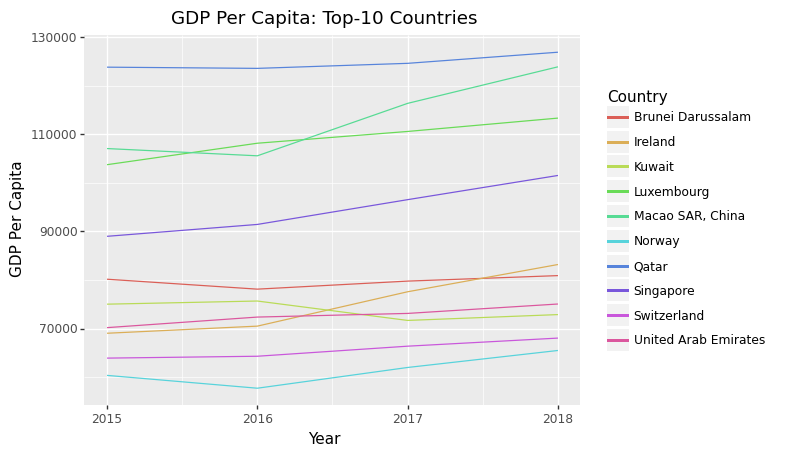

<ggplot: (8757873496896)>

In [32]:
# Getting the countries into a list
top_10_gdp = gdp.sort_values(2018, ascending = False)['Country'][0:10].to_list()

# Making a new dataframe for the plot
gdp_plot_data = gdp_long[gdp_long.Country.isin(top_10_gdp)]

# Fixing a datatype issue that was causing the plot to fail
gdp_plot_data['Year'] = gdp_plot_data['Year'].astype(str).astype(int)

# Plotting
(ggplot(gdp_plot_data, aes('Year', 'GDP', color = 'Country'))
     + geom_line()
     + ggtitle("GDP Per Capita: Top-10 Countries")
     + ylab("GDP Per Capita"))


Nice. Finally, let's see if we can join these data together and look at how healthcare spending, GDP, and happiness all correlate.

# Joining It All Together

In [33]:
top_10_df_long.dtypes

Country     object
Year        object
Value      float64
dtype: object

In [34]:
happy_all.dtypes

Country        object
Year            int64
Score         float64
Health        float64
Freedom       float64
Generosity    float64
dtype: object

In [35]:
gdp_long.dtypes

Country     object
Year        object
GDP        float64
dtype: object

In [36]:
# Converting a datatype to make the join compatible
happy_all['Year'] = happy_all['Year'].astype(str)

# An intermediate merge step
merged_intermediate = pd.merge(hc_spend_df, happy_all[['Country', 'Year', 'Score']], on = ['Country', 'Year'])

# Fixing datatypes again
merged_intermediate['Year'] = merged_intermediate['Year'].astype(int)
gdp_long['Year'] = gdp_long['Year'].astype(int)

# Final combined dataset in long form
final_df = pd.merge(merged_intermediate, gdp_long, on = ['Country', 'Year'])

final_df

,Country,Year,Value,Score,GDP
0,Afghanistan,2015,58.90652847,3.575,1886.692977
1,Afghanistan,2016,60.18867111,3.360,1896.992520
2,Afghanistan,2017,65.70602417,3.794,1934.636754
3,Afghanistan,2018,49.84260941,3.632,1955.006208
4,Angola,2015,108.58293915,4.033,7096.600615
...,...,...,...,...,...
539,Zambia,2018,75.99179077,4.377,4223.906936
540,Zimbabwe,2015,107.68700409,4.610,2679.580317
541,Zimbabwe,2016,113.40885925,4.193,2687.385429
542,Zimbabwe,2017,112.74193573,3.875,2825.725122


Beautiful! Now we have one dataset that contains all of the seperate datafiles we've loaded thus far. We can now explore the relationships between healthcare spending per capita, happiness levels, and GDP per capita, as well as how all of these things change year to year!

First, let's examine the summary statistics and distributions of our fields of interest: Value, Score, and GDP.

In [37]:
final_df[['Value', 'Score', 'GDP']].describe()

,Score,GDP
count,544.000000,544.000000
mean,5.435320,21993.459007
std,1.151116,22578.179960
min,2.693000,737.978583
25%,4.511000,5097.977941
50%,5.398500,14531.501220
75%,6.358000,31761.390592
max,7.632000,126898.425900


/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_ydensity : Removed 12 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


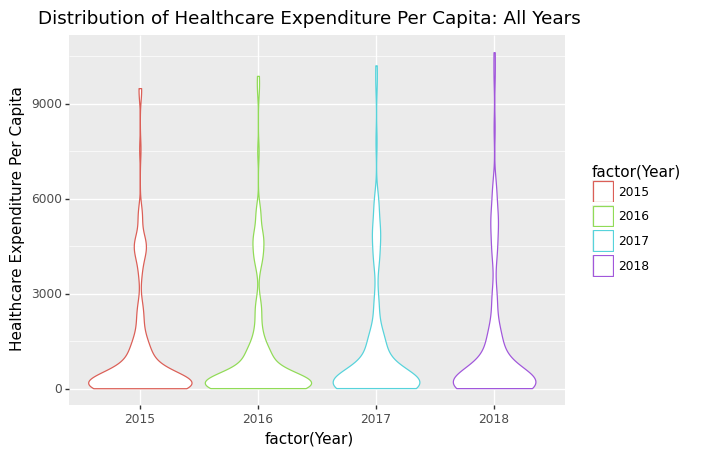

<ggplot: (-9223363278989187349)>

In [53]:
# Healthcare Expenditure Distribution
from plotnine import geom_violin, geom_boxplot

(ggplot(final_df, aes('factor(Year)', 'Value', color = 'factor(Year)'))
     + geom_violin()
     + ggtitle("Distribution of Healthcare Expenditure Per Capita: All Years")
     + ylab("Healthcare Expenditure Per Capita"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 12 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/opt/tljh/user/lib/python3.6/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


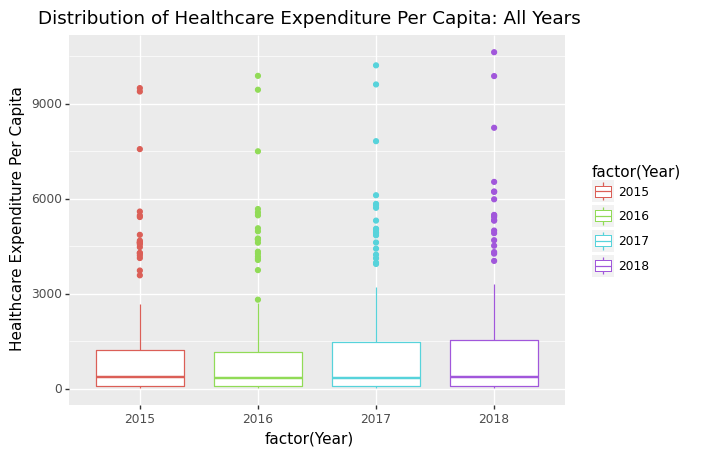

<ggplot: (8757865685410)>

In [52]:
(ggplot(final_df, aes('factor(Year)', 'Value', color = 'factor(Year)'))
     + geom_boxplot()
     + ggtitle("Distribution of Healthcare Expenditure Per Capita: All Years")
     + ylab("Healthcare Expenditure Per Capita"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


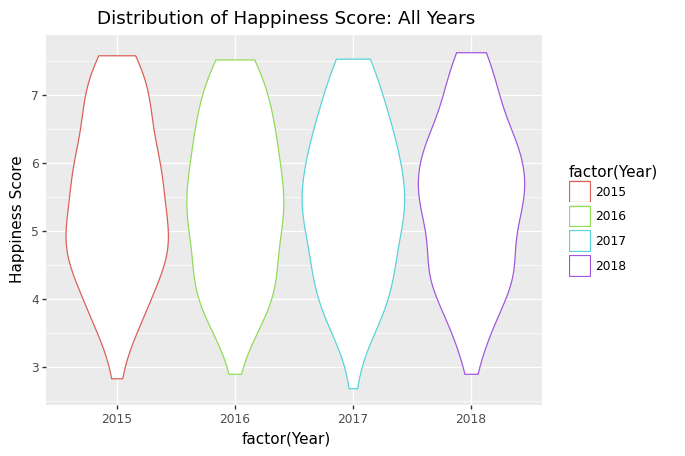

<ggplot: (8757871502319)>

In [40]:
# Happiness Score Distribution
(ggplot(final_df, aes('factor(Year)', 'Score', color = 'factor(Year)'))
     + geom_violin()
     + ggtitle("Distribution of Happiness Score: All Years")
     + ylab("Happiness Score"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


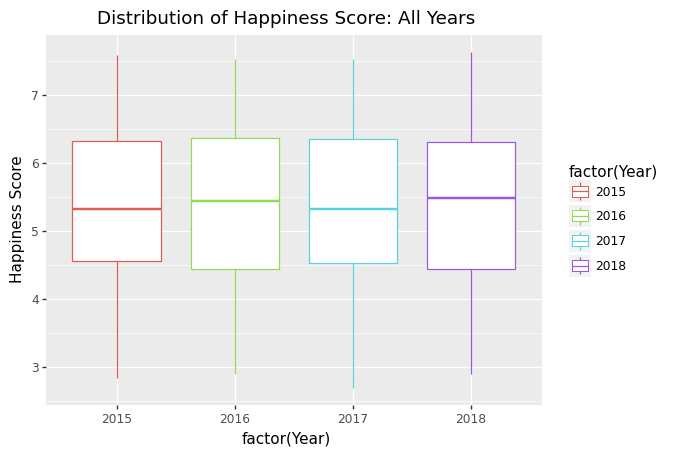

<ggplot: (-9223363278988949472)>

In [41]:
(ggplot(final_df, aes('factor(Year)', 'Score', color = 'factor(Year)'))
     + geom_boxplot()
     + ggtitle("Distribution of Happiness Score: All Years")
     + ylab("Happiness Score"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


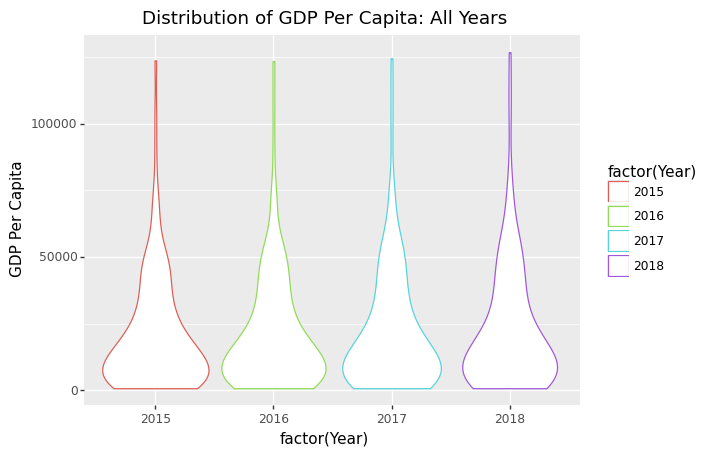

<ggplot: (-9223363278988964671)>

In [42]:
# GDP Per Capita Distribution
(ggplot(final_df, aes('factor(Year)', 'GDP', color = 'factor(Year)'))
     + geom_violin()
     + ggtitle("Distribution of GDP Per Capita: All Years")
     + ylab("GDP Per Capita"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


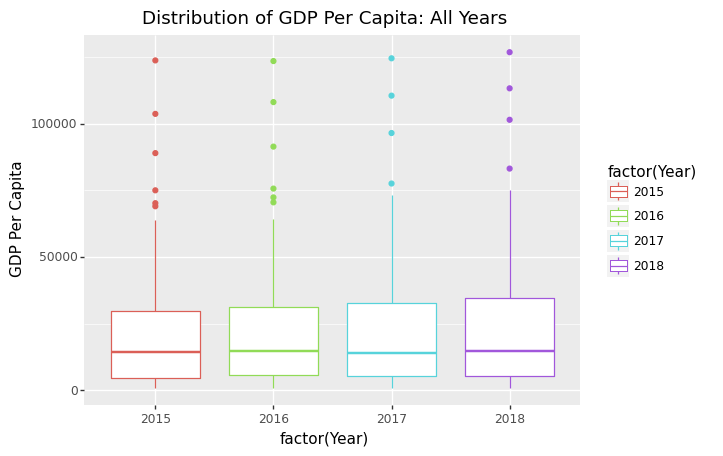

<ggplot: (-9223363278988903950)>

In [43]:
(ggplot(final_df, aes('factor(Year)', 'GDP', color = 'factor(Year)'))
     + geom_boxplot()
     + ggtitle("Distribution of GDP Per Capita: All Years")
     + ylab("GDP Per Capita"))

# Happiness vs. Healthcare Spending

With this joined data we can ask things like:

Does happiness score correlate with healthcare spending? How does that relationship change year to year?

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


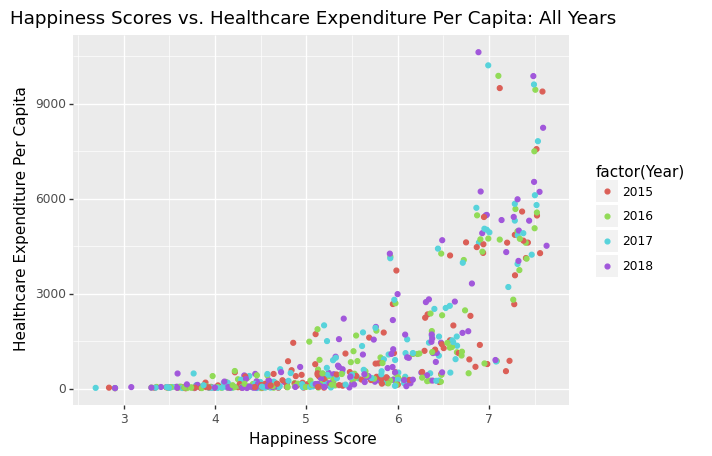

<ggplot: (-9223363278988904062)>

In [44]:
# Importing some new geoms to work with
from plotnine import geom_point

# Cleaning up the Value column a bit for the plot
final_df.Value = final_df.Value.astype(float)

(ggplot(final_df, aes('Score', 'Value', color = 'factor(Year)'))
     + geom_point()
     + ggtitle("Happiness Scores vs. Healthcare Expenditure Per Capita: All Years")
     + ylab("Healthcare Expenditure Per Capita")
     + xlab("Happiness Score"))

What if we wanted to seperate out the years?

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


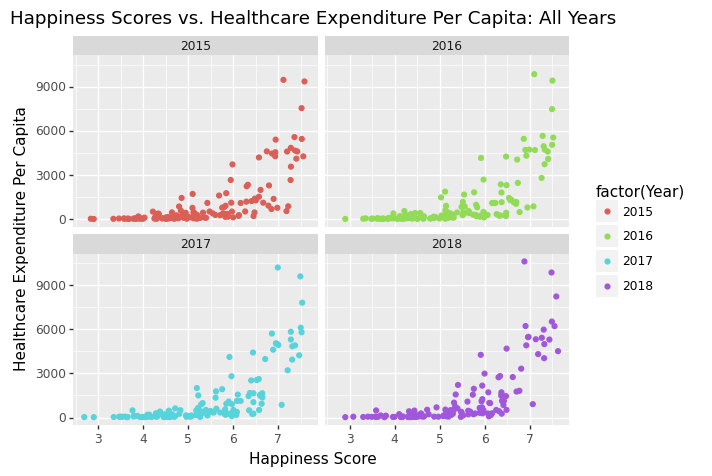

<ggplot: (8757865733296)>

In [45]:
from plotnine import facet_wrap

(ggplot(final_df, aes('Score', 'Value', color = 'factor(Year)'))
     + geom_point()
     + facet_wrap('Year')
     + ggtitle("Happiness Scores vs. Healthcare Expenditure Per Capita: All Years")
     + ylab("Healthcare Expenditure Per Capita")
     + xlab("Happiness Score"))

What if we added a smoothed LOESS line to observe the trend?

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


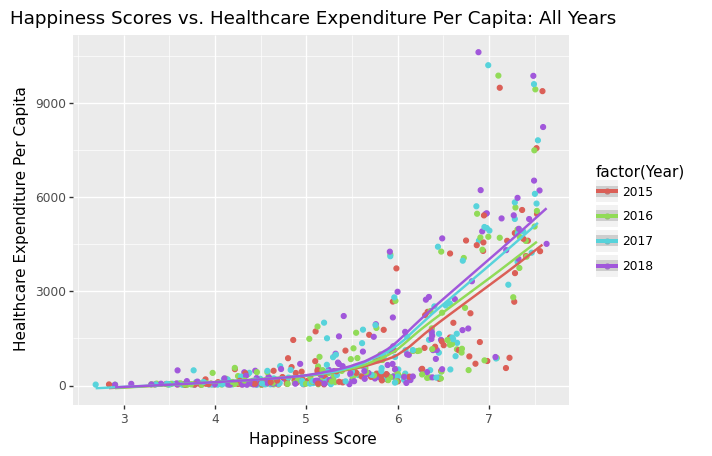

<ggplot: (8757865733142)>

In [46]:
from plotnine import geom_smooth

(ggplot(final_df, aes('Score', 'Value', color = 'factor(Year)'))
     + geom_point()
     + geom_smooth()
     + ggtitle("Happiness Scores vs. Healthcare Expenditure Per Capita: All Years")
     + ylab("Healthcare Expenditure Per Capita")
     + xlab("Happiness Score"))

So what can we discern about the relationship between a countries happiness and it's healthcare expenditure? We see that while not linear, it is certainly a positive correlation. Countries with Happiness Scores less than about 5.5 have fairly low and level healthcare expenditure per capita. For the higher end of the Happiness Score range, we see begin to see greater levels of Healthcare Expediture per Capita. Another thing to point out is that the trend lines are very similar year to year but seem to shift up slightly each year.

# Happiness vs. GDP

We can do a similar analysis comparing happiness to GDP. This basically asks, does higher levels of productivity correlate with happiness?

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


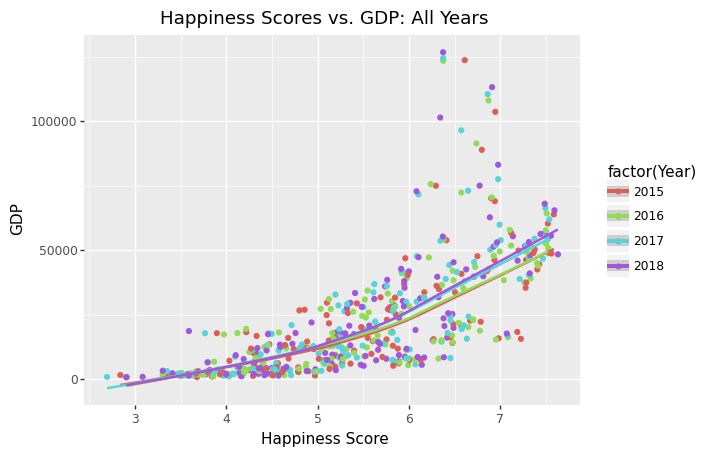

<ggplot: (8757865720447)>

In [47]:
(ggplot(final_df, aes('Score', 'GDP', color = 'factor(Year)'))
     + geom_point()
     + geom_smooth()
     + ggtitle("Happiness Scores vs. GDP: All Years")
     + ylab("GDP")
     + xlab("Happiness Score"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


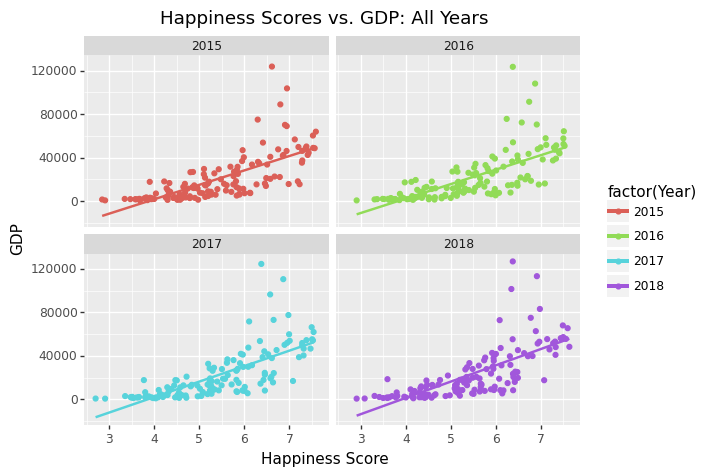

<ggplot: (8757865771889)>

In [48]:
(ggplot(final_df, aes('Score', 'GDP', color = 'factor(Year)'))
     + geom_point()
     + facet_wrap('Year') 
     + geom_smooth(method = 'lm', se = False)
     + ggtitle("Happiness Scores vs. GDP: All Years")
     + ylab("GDP")
     + xlab("Happiness Score"))

The same patterns holds. There are a few outlier countries that break away from the trend line towards the higher end of the happiness scores. Still nothing super surprising: happiness and productivity tend to go hand in hand. However, I'm careful not to use any causal statements. Observational analysis like this cannot establish causation, in prinicple or in direction. Do happier people produce more? Or are people happier because they're more prosperous? Is there a synergy? Is some unobserved third variable causing both happiness and productivity? These kinds of of questions are beyond the scope.

# Healthcare Spending vs. GDP

Lastly, for the sake of completion, let's plot healthcare spending by GDP. Do more productive countries tend to spend more per capita on healthcare?

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


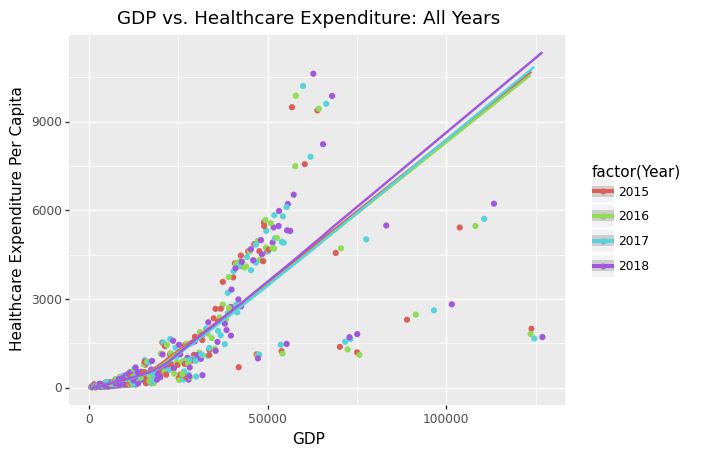

<ggplot: (-9223363278989004000)>

In [49]:
(ggplot(final_df, aes('GDP', 'Value', color = 'factor(Year)'))
     + geom_point()
     + geom_smooth()
     + ggtitle("GDP vs. Healthcare Expenditure: All Years")
     + ylab("Healthcare Expenditure Per Capita")
     + xlab("GDP"))

/opt/tljh/user/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/tljh/user/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


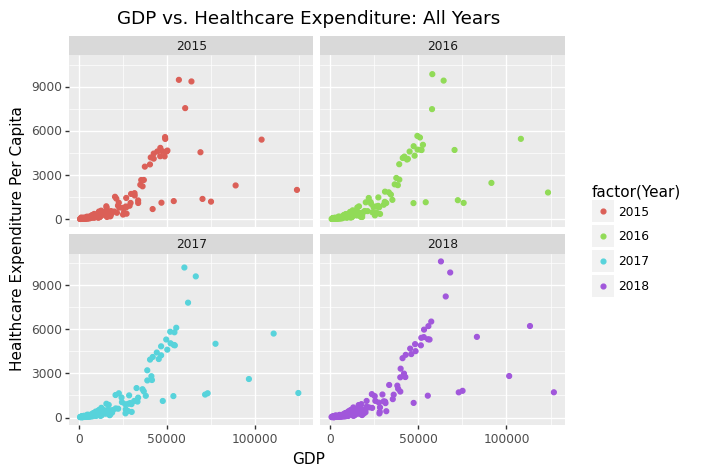

<ggplot: (-9223363278989223715)>

In [50]:
(ggplot(final_df, aes('GDP', 'Value', color = 'factor(Year)'))
     + geom_point()
     + facet_wrap('Year')
     + ggtitle("GDP vs. Healthcare Expenditure: All Years")
     + ylab("Healthcare Expenditure Per Capita")
     + xlab("GDP"))

Interestingly, the plot exhibits a fan shape as the data reaches the higher ranges. This tells me that, while generally higher levels of GDP indicate higher levels of healthcare expediture, there is a lot of variability, and even some outliers who have very high GDP but low levels of healthcare expediture.

# Conclusion

So what can we say? Were my priors correct? Broadly speaking, I think so. All three of the variables tend to correlate positively. We were able to visualize their relationships using scatterplots overlaid with LOESS smoothers.

We've also learned some interesting things about the distributions of the variables using violin plots, box-and-whisker plots, as well as the describe() command to learn their summary statistics.

Overall, I think it was a successful first dive using Python!

### Git Submission Code:

In [51]:
assert False, "DO NOT REMOVE THIS LINE"

AssertionError: DO NOT REMOVE THIS LINE

In [ ]:
%%bash
git pull
git add Final_Proj_Dixon.ipynb
git commit -a -m "Submitting the final assignment"
git push